# Bibliotheken und Funktionen

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 100)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Datentransfer

In [2]:
def load():
    data = pd.read_csv(r"C:\Users\Naime Diler\Desktop\PycharmProjects\datasets\TelcoCustomerChurn-230423-212029.csv")
    return data

df = load()

#  Überprüfung des Gesamtbildes

In [3]:
def check_df(dataframe, head=5):
    print(f"##################### Shape #####################\n")
    print(f"{dataframe.shape}\n")
    print(f"##################### Types #####################\n")
    print(f"{dataframe.dtypes}\n")
    print(f"##################### Head #####################\n")
    print(f"{dataframe.head(head)}\n")
    print(f"##################### Tail #####################\n")
    print(f"{dataframe.tail(head)}\n")
    print(f"##################### NA #####################\n")
    print(f"{dataframe.isnull().sum()}\n")
    print(f"##################### Quantiles #####################\n")
    print(f"{dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T}")


check_df(df)

##################### Shape #####################

(7043, 21)

##################### Types #####################

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

##################### Head #####################

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines  \
0  7590-VHVEG  Female              0     Yes         No       1           No  No phone service   
1  5575-GNVDE    Male              0 

In [4]:
# Beim Überprüfen des DataFrames mit check_df stellen wir fest, dass die Variable "TotalCharges" als kategorisch
# eingestuft wird, obwohl ihre Werte numerisch sind.

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [5]:
# Churn, unsere Zielvariable sollte numerische Werte ausweisen:

df["Churn"] = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)

In [6]:
# Kontrolle:

check_df(df)

##################### Shape #####################

(7043, 21)

##################### Types #####################

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

##################### Head #####################

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines  \
0  7590-VHVEG  Female              0     Yes         No       1           No  No phone service   
1  5575-GNVDE    Male              0 

# Explorative Datenanalyse (EDA)

Erfassung der numerischen und kategorialen Variablen

In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Liefert die Bezeichnungen der kategorialen, numerischen sowie kardinalen, aber dennoch kategorialen Variablen im
    Datensatz.
    Notiz: Hierbei sind auch numerisch erscheinende kategoriale Variablen inbegriffen.

    Parameters
    ------
        dataframe: Dataframe
                DataFrame, aus dem die Variablennamen extrahiert werden sollen.
        cat_th: int, optional
                Grenzwert/ Schwellenwert für Variablen, die numerisch, jedoch kategoriale sind.
        car_th: int, optional
                Grenzwert für kategoriale, jedoch kardinale Variablen.

    Returns
    ------
        cat_cols: list
                Liste der kategorialen Variablen
        num_cols: list
                Liste der numerischen Variablen
        cat_but_car: list
                Liste der kardinalen Variablen mit kategorialem Erscheinungsbild

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = Gesamtanzahl der Variablen
        num_but_cat ist in cat_cols enthalten.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 2


In [8]:
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen',
 'Churn']

In [9]:
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [10]:
cat_but_car

['customerID']

# Analyse der kategorialen Variablen

In [11]:
def cat_summary(dataframe, cat_cols, plot=False):
    for col_name in cat_cols:
        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")
        if plot:
            sns.countplot(x=dataframe[col_name], data=dataframe)
            plt.show()


cat_summary(df, cat_cols)

        gender  Ratio
gender               
Male      3555 50.476
Female    3488 49.524
##########################################
         Partner  Ratio
Partner                
No          3641 51.697
Yes         3402 48.303
##########################################
            Dependents  Ratio
Dependents                   
No                4933 70.041
Yes               2110 29.959
##########################################
              PhoneService  Ratio
PhoneService                     
Yes                   6361 90.317
No                     682  9.683
##########################################
                  MultipleLines  Ratio
MultipleLines                         
No                         3390 48.133
Yes                        2971 42.184
No phone service            682  9.683
##########################################
                 InternetService  Ratio
InternetService                        
Fiber optic                 3096 43.959
DSL                         24

- Etwa die Hälfte unserer Kunden im Datensatz sind männlich, während die andere Hälfte weiblich ist.
- Rund 50% der Kunden haben einen Partner und sind somit verheiratet.
- Lediglich 30% der Gesamtkunden haben Personen, für die sie Verantwortung tragen.
- 90% der Kunden nutzen Telefonleistungen.
- Von diesen Telefonnutzern besitzen 53% keine Mehrfachleitungen.
- Es gibt einen Anteil von 21% an Kunden, die keinen Internetdienstanbieter haben.
- Die Mehrheit der Kunden schließt monatliche Verträge ab, wobei sich eine ähnliche Anzahl von Kunden für ein- und
  zweijährige Verträge entscheidet.
- 60% der Kunden haben sich für papierlose Rechnungen entschieden.
- Etwa 26% der Kunden haben die Plattform im letzten Monat verlassen.
- 16% der Kunden im Datensatz sind älter. Somit sind die meisten Kunden in den Daten jung.

# Analyse der numerischen Variablen

In [12]:
def num_summary(dataframe, num_cols, plot=False):
    for col in num_cols:
        quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
        print(f"{col}:\n{dataframe[col].describe(quantiles).T}")

        if plot:
            dataframe[col].hist(bins=20)
            plt.xlabel(col)
            plt.title(col)
            plt.show()


num_summary(df, num_cols)

tenure:
count   7043.000
mean      32.371
std       24.559
min        0.000
5%         1.000
10%        2.000
20%        6.000
30%       12.000
40%       20.000
50%       29.000
60%       40.000
70%       50.000
80%       60.000
90%       69.000
95%       72.000
99%       72.000
max       72.000
Name: tenure, dtype: float64
MonthlyCharges:
count   7043.000
mean      64.762
std       30.090
min       18.250
5%        19.650
10%       20.050
20%       25.050
30%       45.850
40%       58.830
50%       70.350
60%       79.100
70%       85.500
80%       94.250
90%      102.600
95%      107.400
99%      114.729
max      118.750
Name: MonthlyCharges, dtype: float64
TotalCharges:
count   7032.000
mean    2283.300
std     2266.771
min       18.800
5%        49.605
10%       84.600
20%      267.070
30%      551.995
40%      944.170
50%     1397.475
60%     2048.950
70%     3141.130
80%     4475.410
90%     5976.640
95%     6923.590
99%     8039.883
max     8684.800
Name: TotalCharges, dtype: fl

Bei der Betrachtung der Kundenbindung sehen wir zunächst eine große Anzahl von Kunden, die seit einem Monat dabei sind,
gefolgt von Kunden mit einer Bindungsdauer von 70 Monaten.

# Analyse der Zielvariable

Berechnung des Durchschnitts der Zielvariable basierend auf kategorialen und numerischen Variablen

In [13]:
# kategorial:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                         "Count": dataframe[categorical_col].value_counts(),
                         "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")


target_summary_with_cat(df, "Churn", "gender")

        TARGET_MEAN  Count  Ratio
gender                           
Female        0.269   3488 49.524
Male          0.262   3555 50.476




In [14]:
for col in cat_cols:
    target_summary_with_cat(df, "Churn", col)

        TARGET_MEAN  Count  Ratio
gender                           
Female        0.269   3488 49.524
Male          0.262   3555 50.476


         TARGET_MEAN  Count  Ratio
Partner                           
No             0.330   3641 51.697
Yes            0.197   3402 48.303


            TARGET_MEAN  Count  Ratio
Dependents                           
No                0.313   4933 70.041
Yes               0.155   2110 29.959


              TARGET_MEAN  Count  Ratio
PhoneService                           
No                  0.249    682  9.683
Yes                 0.267   6361 90.317


                  TARGET_MEAN  Count  Ratio
MultipleLines                              
No                      0.250   3390 48.133
No phone service        0.249    682  9.683
Yes                     0.286   2971 42.184


                 TARGET_MEAN  Count  Ratio
InternetService                           
DSL                    0.190   2421 34.375
Fiber optic            0.419   3096 43.959
No        

In [15]:
# oder:

def target_summary_with_cat1(dataframe, target, cat_cols):
    for col in cat_cols:
        print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(col)[target].mean(),
                         "Count": dataframe[col].value_counts(),
                         "Ratio": 100 * dataframe[col].value_counts() / len(dataframe)}), end="\n\n\n")

target_summary_with_cat1(df, "Churn", cat_cols)

        TARGET_MEAN  Count  Ratio
gender                           
Female        0.269   3488 49.524
Male          0.262   3555 50.476


         TARGET_MEAN  Count  Ratio
Partner                           
No             0.330   3641 51.697
Yes            0.197   3402 48.303


            TARGET_MEAN  Count  Ratio
Dependents                           
No                0.313   4933 70.041
Yes               0.155   2110 29.959


              TARGET_MEAN  Count  Ratio
PhoneService                           
No                  0.249    682  9.683
Yes                 0.267   6361 90.317


                  TARGET_MEAN  Count  Ratio
MultipleLines                              
No                      0.250   3390 48.133
No phone service        0.249    682  9.683
Yes                     0.286   2971 42.184


                 TARGET_MEAN  Count  Ratio
InternetService                           
DSL                    0.190   2421 34.375
Fiber optic            0.419   3096 43.959
No        

- Die Churn-Raten bei männlichen und weiblichen Kunden sind nahezu ausgeglichen.
- Kunden mit Partnern und abhängigen Personen (dependents) weisen eine niedrigere Churn-Rate auf.
- Es zeigt sich kein Unterschied bei den Diensten PhoneServise und MultipleLines.
- Die Verlustquote ist bei Fiber-Optik-Internetdiensten deutlich höher.
- Kunden ohne Dienste wie OnlineSecurity, OnlineBackup und TechSupport weisen eine hohe Churn-Rate auf.
- Im Vergleich zu Kunden mit ein- oder zweijährigen Verträgen weist eine größere Anzahl von Kunden mit monatlichem
- Abonnement eine höhere Churn-Rate auf.
- Kunden ohne Papierrechnung weisen eine höhere Churn-Rate auf.
- Kunden, die die Zahlungsmethode ElectronicCheck verwenden, neigen eher dazu, die Plattform zu verlassen, im Vergleich
  zu anderen Optionen.
- Die Churn-Rate ist bei älteren Kunden höher.

In [16]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")


target_summary_with_num(df, "Churn","tenure")

       tenure
Churn        
0      37.570
1      17.979




In [17]:
for col in num_cols:
    target_summary_with_num(df, "Churn", col)

       tenure
Churn        
0      37.570
1      17.979


       MonthlyCharges
Churn                
0              61.265
1              74.441


       TotalCharges
Churn              
0          2555.344
1          1531.796




In [18]:
# oder:
def target_summary_with_num1(dataframe, target, num_cols):
    for col in num_cols:
        print(dataframe.groupby(target).agg({col: "mean"}), end="\n\n\n")

target_summary_with_num1(df, "Churn", num_cols)

       tenure
Churn        
0      37.570
1      17.979


       MonthlyCharges
Churn                
0              61.265
1              74.441


       TotalCharges
Churn              
0          2555.344
1          1531.796




Bei der Analyse der Beziehung zwischen Kundenbindung (Tenure) und Kundenabwanderung (Churn) fällt auf, dass die Kunden,
die nicht abgewandert sind, bereits seit längerer Zeit Kunden sind. Betrachten wir hingegen die monatlichen Gebühren
und Kundenabwanderung, so zeigt sich, dass die durchschnittlichen monatlichen Zahlungen der abgewanderten Kunden höher
sind.

# Korrelationsanalyse

In [19]:
df[num_cols].corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000,0.248,0.826
MonthlyCharges,0.248,1.000,0.651
TotalCharges,0.826,0.651,1.000


Korrelationsmatrix

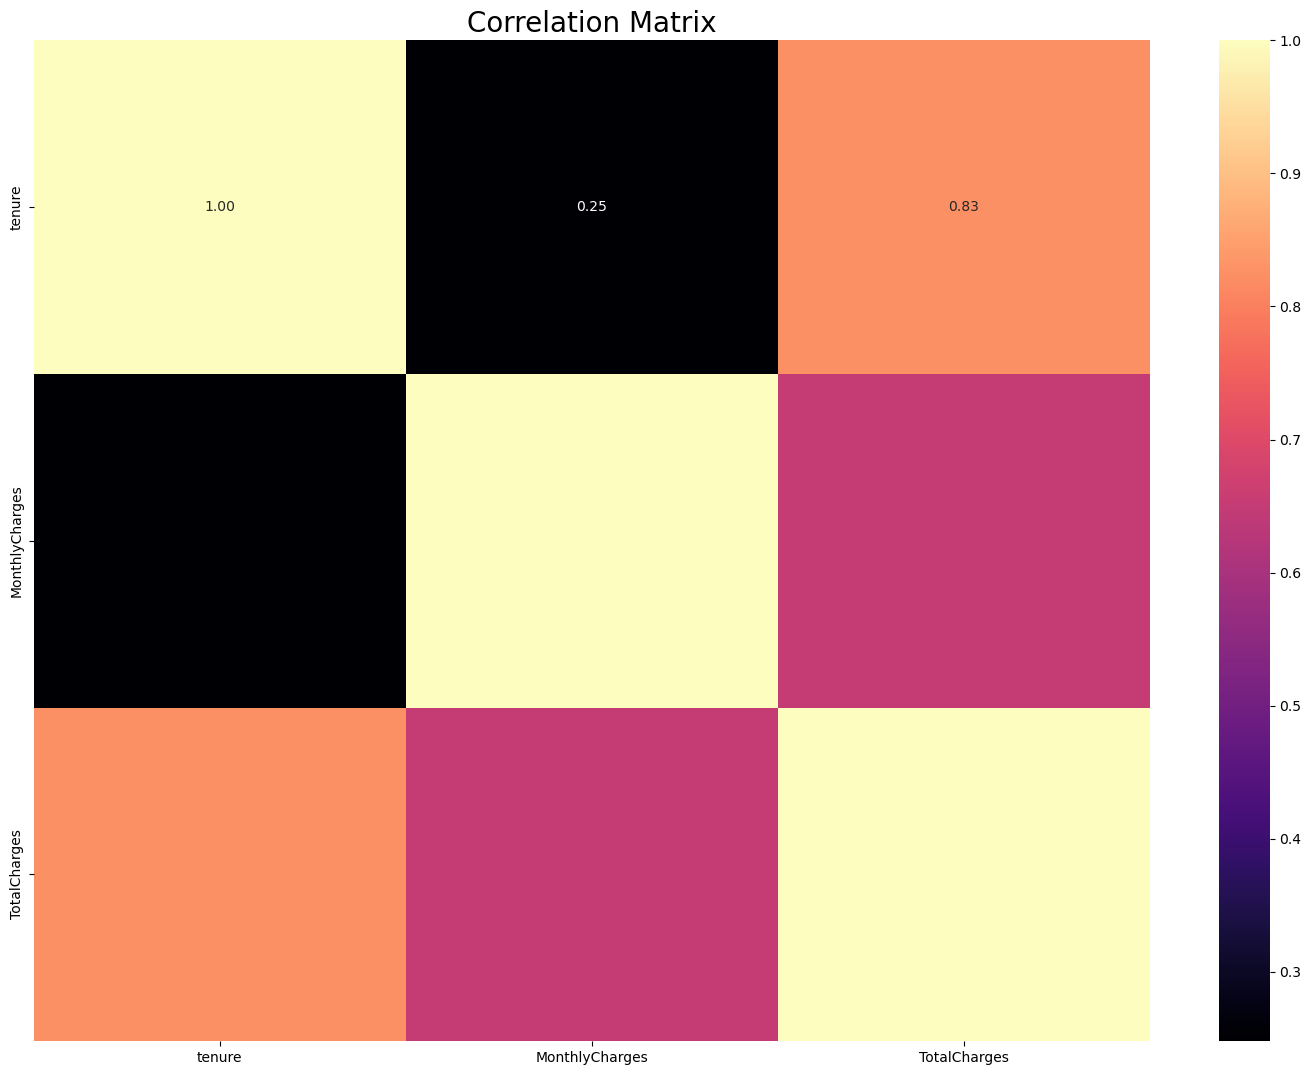

In [20]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

# TotalCharges zeigt eine hohe Korrelation mit den monatlichen Gebühren und der Kundenbindung (Tenure).

# Feature Engineering

# Analyse der Ausreißer (outliers)

In [21]:
# 1. Berechnung der unteren und oberen Ausreißerschwelle:

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):   # könnte auch q1=0.05, q2=0.95 angeben
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

low, up = outlier_thresholds(df, "tenure")

In [22]:
# 2.Identifizierung von Ausreißern:

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    

check_outlier(df, "tenure")

False

In [23]:
for col in num_cols:
    print(check_outlier(df, col))

False
False
False


In [24]:
# Keine Ausreißer gefunden; falls vorhanden, kann dieser Schritt durchgeführt werden:


# 3. Datenbereinigung durch Ersetzen von Ausreißern mit Schwellenwerten:

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in num_cols:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

tenure False
MonthlyCharges False
TotalCharges False


# Analyse der fehlenden Werte (missing values)

In [25]:
df.isnull().values.any()

True

In [26]:
df.isnull().sum()         

# Missing Values nur bei TotalCharges

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

oder:

In [27]:
def missing_values_table(dataframe, na_name=False):
    """
    Diese Funktion identifiziert Spalten mit fehlenden Werten (NA). Sie gibt die Anzahl der NA-Werte in diesen Spalten
    sowie deren Anteil an den Gesamtdaten an. Bei Bedarf gibt sie auch die Namen der Spalten mit NA-Werten aus.

    Parameters:
        dataframe: der Name des DataFrames
        na_name:  der Name der Spalte mit NA-Werten

    Returns:

    """

    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns


na_columns = missing_values_table(df, na_name=True)

              n_miss  ratio
TotalCharges      11  0.160


In [28]:
# Fehlende Werte in der Spalte 'TotalCharges' mit Nullen auffüllen:

df["TotalCharges"].fillna(0, inplace=True)

oder:

In [29]:
# Fehlende Werte in der Spalte 'TotalCharges' durch den Median ersetzen:

df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

In [30]:
df.isnull().values.any()

False

# Feature Extraction

Vor Feature Engineering wird zunächst ein Basismodell erstellt.:

Ein Basismodell dient als Ausgangspunkt zur Beurteilung der Modellleistung und ermöglicht die Bewertung der Effekte 
von Feature-Engineering-Methoden auf diese Leistung, um festzustellen, ob sie tatsächlich Verbesserungen bewirken.

Das Basismodell ermöglicht ebenso eine anfängliche Bewertung der Modellleistung anhand vorhandener Merkmale, was ein besseres 
Verständnis der Daten und ihrer Muster fördert. Diese Erkenntnisse erleichtern die Auswahl passender
Feature-Engineering-Techniken.

In [31]:
dff = df.copy()
cat_cols = [col for col in cat_cols if col not in ["Churn"]]
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen']

In [32]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

dff = one_hot_encoder(dff, cat_cols, drop_first=True)

In [33]:
dff.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1
0,7590-VHVEG,1,29.850,29.850,0,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False
1,5575-GNVDE,34,56.950,1889.500,0,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False
2,3668-QPYBK,2,53.850,108.150,1,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
3,7795-CFOCW,45,42.300,1840.750,0,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False
4,9237-HQITU,2,70.700,151.650,1,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False


# Base Model

In [34]:
y = dff["Churn"]
X = dff.drop(["Churn", "customerID"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

catboost_model = CatBoostClassifier(verbose=False, random_state=12345).fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)

# rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
# y_pred = rf_model.predict(X_test)


print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test), 2)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.79
Recall: 0.65
Precision: 0.51
F1: 0.57
Auc: 0.74


# Erstellung neuer Variablen

In [35]:
# Erstellung einer jährlichen kategorialen Variable aus der Variablen 'Tenure:

df.loc[(df["tenure"]>=0) & (df["tenure"]<=12),"NEW_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["tenure"]>12) & (df["tenure"]<=24),"NEW_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["tenure"]>24) & (df["tenure"]<=36),"NEW_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["tenure"]>36) & (df["tenure"]<=48),"NEW_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["tenure"]>48) & (df["tenure"]<=60),"NEW_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["tenure"]>60) & (df["tenure"]<=72),"NEW_TENURE_YEAR"] = "5-6 Year"

In [36]:
# Kennzeichnung von Kunden mit Vertragslaufzeiten von 1 oder 2 Jahren als "Engaged":

df["NEW_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year", "Two year"] else 0)

In [37]:
# Personen ohne jegliche Form von Unterstützung, Backup oder Absicherung:

df["NEW_noProt"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

In [38]:
# Junge Kunden mit monatlichen Verträgen:

df["NEW_Young_Not_Engaged"] = df.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis=1)

In [39]:
# Die Gesamtanzahl der in Anspruch genommenen Serviceleistungen einer Person:

df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)

In [40]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_TENURE_YEAR,NEW_Engaged,NEW_noProt,NEW_Young_Not_Engaged,NEW_TotalServices
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0,0-1 Year,0,1,1,1
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0,2-3 Year,1,1,0,3
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1,0-1 Year,0,1,1,3
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0,3-4 Year,1,1,0,3
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1,0-1 Year,0,1,1,1


In [41]:
# Personen, die einen Streaming-Dienst nutzen:

df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

In [42]:
# Nutzt die Person die automatische Zahlungsabwicklung?:

df["NEW_FLAG_AutoPayment"] = df["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)

In [43]:
# Durchschnittliche monatliche Zahlungsrate:

df["NEW_AVG_Charges"] = df["TotalCharges"] / (df["tenure"])
df.loc[df["tenure"]==0, "NEW_AVG_Charges"] = 0

In [44]:
# Anstieg des aktuellen Preises im Vergleich zum Durchschnittspreis:

df["NEW_Increase"] = df["NEW_AVG_Charges"] / df["MonthlyCharges"]

In [45]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_TENURE_YEAR,NEW_Engaged,NEW_noProt,NEW_Young_Not_Engaged,NEW_TotalServices,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0,0-1 Year,0,1,1,1,0,0,29.850,1.000
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0,2-3 Year,1,1,0,3,0,0,55.574,0.976
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1,0-1 Year,0,1,1,3,0,0,54.075,1.004
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0,3-4 Year,1,1,0,3,0,1,40.906,0.967
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1,0-1 Year,0,1,1,1,0,0,75.825,1.072


In [46]:
# Preis pro Serviceleistung

df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)

In [47]:
# Überprüfung von Partnerschaft und abhängigen Personen:

df["NEW_PD"] = df.apply(lambda x: 1 if (x["Partner"]== "No") & (x["Dependents"]=="No") else 0, axis=1)

In [48]:
# elektronische Abrechnung und Zahlungsmethode:

df["NEW_EP"] = df.apply(lambda x: 1 if (x["PaperlessBilling"]== "Yes") & (x["PaymentMethod"]=="Electronic check ") else 0, axis=1)

In [49]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_TENURE_YEAR,NEW_Engaged,NEW_noProt,NEW_Young_Not_Engaged,NEW_TotalServices,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,NEW_PD,NEW_EP
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0,0-1 Year,0,1,1,1,0,0,29.850,1.000,14.925,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0,2-3 Year,1,1,0,3,0,0,55.574,0.976,14.238,1,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1,0-1 Year,0,1,1,3,0,0,54.075,1.004,13.463,1,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0,3-4 Year,1,1,0,3,0,1,40.906,0.967,10.575,1,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1,0-1 Year,0,1,1,1,0,0,75.825,1.072,35.350,1,0


In [50]:
df.shape

(7043, 33)

# Encoding

In [51]:
# Aktualisierung der Kategorisierung nach Variablentypen:

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 33
cat_cols: 26
num_cols: 6
cat_but_car: 1
num_but_cat: 10


In [52]:
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'NEW_TENURE_YEAR',
 'SeniorCitizen',
 'Churn',
 'NEW_Engaged',
 'NEW_noProt',
 'NEW_Young_Not_Engaged',
 'NEW_TotalServices',
 'NEW_FLAG_ANY_STREAMING',
 'NEW_FLAG_AutoPayment',
 'NEW_PD',
 'NEW_EP']

In [53]:
num_cols

['tenure',
 'MonthlyCharges',
 'TotalCharges',
 'NEW_AVG_Charges',
 'NEW_Increase',
 'NEW_AVG_Service_Fee']

In [54]:
cat_but_car

['customerID']

Label Encoding

In [55]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

In [56]:
for col in binary_cols:
    df = label_encoder(df, col)

In [57]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_TENURE_YEAR,NEW_Engaged,NEW_noProt,NEW_Young_Not_Engaged,NEW_TotalServices,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,NEW_PD,NEW_EP
0,7590-VHVEG,0,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.850,29.850,0,0-1 Year,0,1,1,1,0,0,29.850,1.000,14.925,0,0
1,5575-GNVDE,1,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.950,1889.500,0,2-3 Year,1,1,0,3,0,0,55.574,0.976,14.238,1,0
2,3668-QPYBK,1,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.850,108.150,1,0-1 Year,0,1,1,3,0,0,54.075,1.004,13.463,1,0
3,7795-CFOCW,1,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.300,1840.750,0,3-4 Year,1,1,0,3,0,1,40.906,0.967,10.575,1,0
4,9237-HQITU,0,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.700,151.650,1,0-1 Year,0,1,1,1,0,0,75.825,1.072,35.350,1,0


One-Hot Encoding

In [58]:
# Aktualisierung der cat_cols-Liste

cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn", "NEW_TotalServices"]]
cat_cols

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod',
 'NEW_TENURE_YEAR',
 'SeniorCitizen',
 'NEW_Engaged',
 'NEW_noProt',
 'NEW_Young_Not_Engaged',
 'NEW_FLAG_ANY_STREAMING',
 'NEW_FLAG_AutoPayment',
 'NEW_PD',
 'NEW_EP']

In [59]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

In [60]:
df.head()

,customerID,gender,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_TotalServices,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NEW_TENURE_YEAR_1-2 Year,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year,SeniorCitizen_1,NEW_Engaged_1,NEW_noProt_1,NEW_Young_Not_Engaged_1,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AutoPayment_1,NEW_PD_1
0,7590-VHVEG,0,1,0,1,0,1,29.850,29.850,0,1,29.850,1.000,14.925,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False
1,5575-GNVDE,1,0,0,34,1,0,56.950,1889.500,0,3,55.574,0.976,14.238,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,True,False,False,False,True
2,3668-QPYBK,1,0,0,2,1,1,53.850,108.150,1,3,54.075,1.004,13.463,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False,True
3,7795-CFOCW,1,0,0,45,0,0,42.300,1840.750,0,3,40.906,0.967,10.575,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,True,False,False,True,True
4,9237-HQITU,0,0,0,2,1,1,70.700,151.650,1,1,75.825,1.072,35.350,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,True


# Standardisierung der numerischen Variablen

In [61]:
ss = StandardScaler()
df[num_cols] = ss.fit_transform(df[num_cols])

In [62]:
df.head()

,customerID,gender,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_TotalServices,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NEW_TENURE_YEAR_1-2 Year,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year,SeniorCitizen_1,NEW_Engaged_1,NEW_noProt_1,NEW_Young_Not_Engaged_1,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AutoPayment_1,NEW_PD_1
0,7590-VHVEG,0,1,0,-1.277,0,1,-1.160,-0.993,0,1,-1.151,0.020,-0.311,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False
1,5575-GNVDE,1,0,0,0.066,1,0,-0.260,-0.172,0,3,-0.301,-0.354,-0.410,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,True,False,False,False,True
2,3668-QPYBK,1,0,0,-1.237,1,1,-0.363,-0.958,1,3,-0.351,0.085,-0.522,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False,True
3,7795-CFOCW,1,0,0,0.514,0,0,-0.747,-0.194,0,3,-0.786,-0.490,-0.939,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,True,False,False,True,True
4,9237-HQITU,0,0,0,-1.237,1,1,0.197,-0.939,1,1,0.368,1.142,2.636,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,True


In [63]:
df.shape

(7043, 47)

# Modellierung und Bewertung (Modeling and Evaluation)

In [64]:
y = df["Churn"]
X = df.drop(["Churn","customerID"], axis=1)

In [65]:
# train -> %70 (Wir trainieren das Modell)  test->30 (Zur Evaluierung der Modellleistung nutzen wir den Testdatensatz)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [66]:
X_train.shape

(4930, 45)

In [67]:
y_train.shape

(4930,)

In [68]:
X_test.shape

(2113, 45)

In [69]:
y_test.shape

(2113,)

In [70]:
catboost_model = CatBoostClassifier(verbose=False, random_state=12345).fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),2)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.8
Recall: 0.66
Precision: 0.52
F1: 0.58
Auc: 0.75


### Base Model:

Accuracy: 0.78
Recall: 0.63
Precision: 0.49
F1: 0.55
Auc: 0.73

Nach der Implementierung von Feature-Engineering-Techniken haben wir eine deutliche Verbesserung der Modellleistung im 
Vergleich zum Basismodell festgestellt. Die Anpassungen führten zu einer höheren Genauigkeit (accuracy), einem erhöhten 
Rückrufwert (Recall) und einem verbesserten F1-Score, was darauf hindeutet, dass das Modell nun besser in der Lage ist, 
Abwanderung vorherzusagen. Die Genauigkeit (accuracy) stieg auf 0.79, der Rückrufwert (Recall) auf 0.65, die Präzision 
(Precision) auf 0.50 und der F1-Score auf 0.57, während die AUC-ROC-Kennzahl bei 0.74 lag.

# Feature Importance

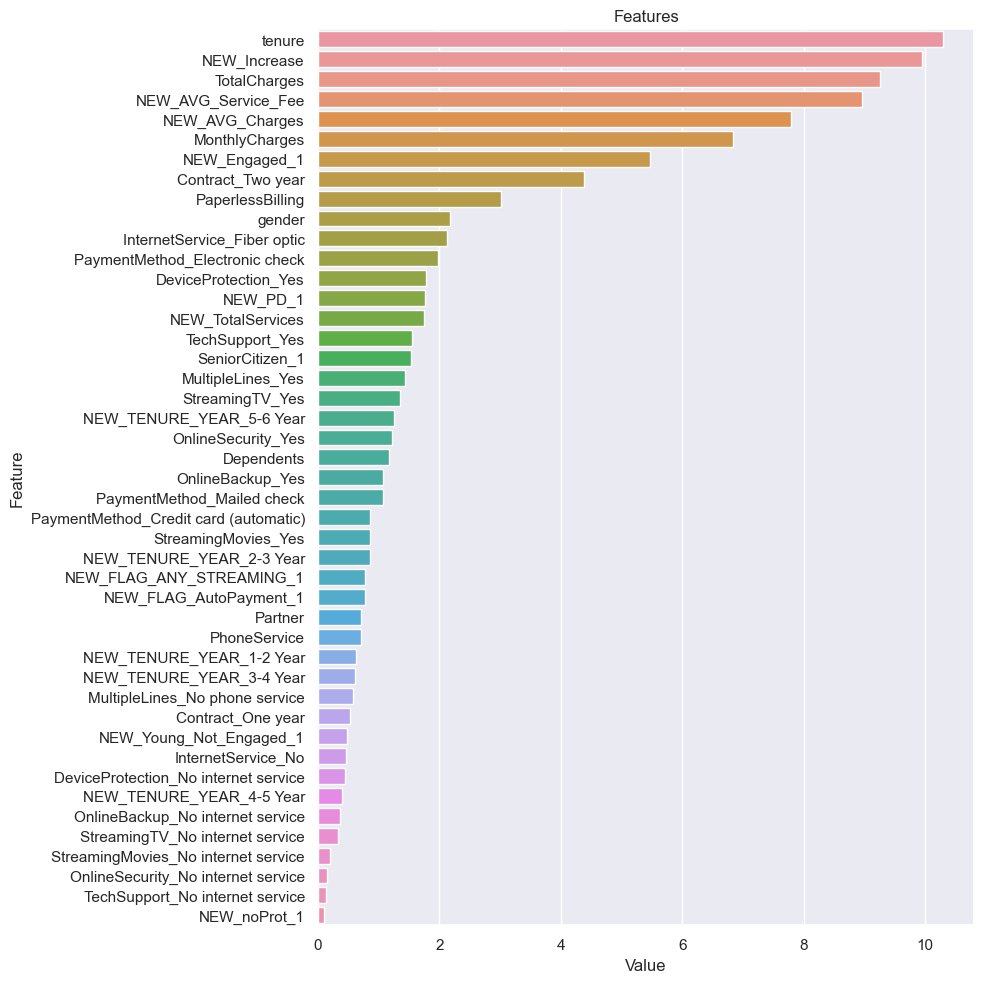

In [71]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(catboost_model, X)